# Generating Hierarchical Data


In [81]:

from typing import List, Dict

from PIL import Image

from notebooks.hierarchy_plotting import *

image_width = 5
samples_per_pixel = 100
eta = 1 # GEM alpha parameter - controls distribution along path
alpha = 1E0 # 
beta = 0.01

two_level_tree =\
[Node('white', [
        Node('red', None),
        Node('green', None),
        Node('blue', None)
    ])
]

three_level_tree =\
[Node('white', [
        Node('red', [
            Node('green', None)
        ]),
        Node('blue', None)
    ])
]

four_level_tree =\
[Node('white', [
        Node('red', [
            Node('green', [
                Node('blue', None)
            ])
        ])
    ])
]


Now to generate images!


{'white': 6, 'red': 1, 'green': 91, 'blue': 2}
{'white': 94, 'red': 3, 'green': 0, 'blue': 3}
{'white': 43, 'red': 1, 'green': 56, 'blue': 0}
{'white': 4, 'red': 0, 'green': 95, 'blue': 1}
{'white': 25, 'red': 1, 'green': 72, 'blue': 2}
{'white': 96, 'red': 2, 'green': 2, 'blue': 0}
{'white': 93, 'red': 5, 'green': 0, 'blue': 2}
{'white': 37, 'red': 2, 'green': 60, 'blue': 1}
{'white': 92, 'red': 7, 'green': 0, 'blue': 1}
{'white': 70, 'red': 28, 'green': 2, 'blue': 0}
{'white': 16, 'red': 1, 'green': 81, 'blue': 2}
{'white': 37, 'red': 61, 'green': 0, 'blue': 2}
{'white': 25, 'red': 75, 'green': 0, 'blue': 0}
{'white': 29, 'red': 68, 'green': 2, 'blue': 1}
{'white': 43, 'red': 57, 'green': 0, 'blue': 0}
{'white': 24, 'red': 73, 'green': 2, 'blue': 1}
{'white': 12, 'red': 88, 'green': 0, 'blue': 0}
{'white': 89, 'red': 2, 'green': 1, 'blue': 8}
{'white': 73, 'red': 23, 'green': 1, 'blue': 3}
{'white': 41, 'red': 58, 'green': 1, 'blue': 0}
{'white': 21, 'red': 0, 'green': 1, 'blue': 78}

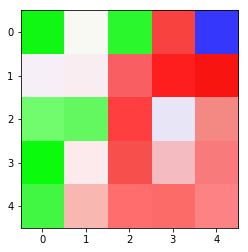

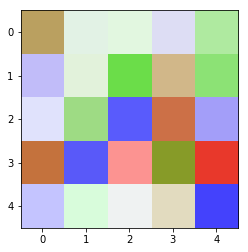

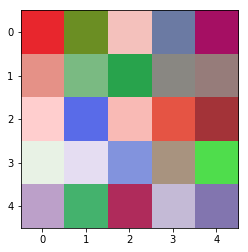

In [82]:

def sample_path(tree : List[Node], prior : Dict[str, int], alpha : float, partial_path = None):
    if partial_path is None:
	    partial_path = list()
    if tree is None:
        return partial_path, prior
    weights = np.array([prior[node[0]] + alpha for node in tree])
    choice = np.argmax(np.random.multinomial(1, weights / float(np.sum(weights))))
    next_node = tree[choice]
    prior[next_node[0]] += 1
    return sample_path(next_node[1], prior, alpha, partial_path + [next_node])

def sample_topic_weights_dp(path, eta):
    weights = {'white': 0, 'red': 0, 'green': 0, 'blue': 0}
    stick_len = 1
    for node in path[:-1]:
        weights[node[0]] = stick_len * np.random.beta(1, eta)
        stick_len -= weights[node[0]]
    weights[path[-1][0]] = stick_len
    return weights

def sample_topic_weights_dirichlet(path, prior, alpha):
    weights = {}
    for node in path:
        weights[node[0]] = prior[node[0]] + alpha
    return weights

def sample_words(num_words, prior, beta):
    keys = list(prior.keys())
    weights = np.array([prior[node_name] + beta for node_name in keys])
    words = np.random.multinomial(num_words, weights / float(np.sum(weights)))
    return {keys[i]: words[i] for i in range(len(keys))}

def generate_image(image_size, tree, alpha, beta, eta, num_words=100):
    image = Image.new('RGB', (image_size, image_size), color=(0,0,0))
    pixels = image.load()
    path_prior = {'white': 0, 'red': 0, 'green': 0, 'blue': 0}
    topic_prior = {'white': 0, 'red': 0, 'green': 0, 'blue': 0}
    colors = {'white': [1,1,1], 'red': [1,0,0], 'green': [0,1,0], 'blue': [0,0,1]}
    for x in range(image_size):
        for y in range(image_size):
            path, path_prior = sample_path(tree, path_prior, alpha)
            topic_weights = sample_topic_weights_dp(path, eta)
            words = sample_words(num_words, topic_weights, beta)
            print(words)
            for color, count in words.items():
                pixels[x,y] = tuple(pixels[x,y][color_idx] + colors[color][color_idx] * count
                                    for color_idx in range(3))
            pixels[x,y] = tuple(int(pixels[x,y][color_idx] * 255. / num_words)
                                for color_idx in range(3))
    return np.array(image, dtype=np.uint8)

plt.figure(1)
plt.imshow(generate_image(image_width, two_level_tree, alpha, beta, eta))
plt.figure(2)
plt.imshow(generate_image(image_width, three_level_tree, alpha, beta, eta))
plt.figure(3)
plt.imshow(generate_image(image_width, four_level_tree, alpha, beta, eta))